___Author(s): Chaojie Feng___<br/>
___Collaborator(s): XXX___<br/>
___External Resources: XXX___<br/>
___Specific Contributions: XXX___<br/>
___Aggregate Contributions: XXX___<br/>


# System Definition
You will consider a 2 wheeled robot similar to the one shown in Fig. 1. It has two wheels of radius r = 20mm,
separated by a distance w = 85mm. It drags a tail for stability.
Figure 1: Two wheeled tank-drive robot
1
Each wheel is powered independently by a bi-directional continuous rotation servo—part number FS90R—with
the angular velocity of the wheel controlled by a signal from the microcontroller. This allows the robot to drive
forwards or backwards at variable speed, or turn with any turning radius. There may be slippage between the wheels
and the floor; assume the resulting effective angular speed of the wheels is normal with a standard deviation of 5%
of the max motor speed.
The robot has two laser range sensors—part number VL53L0X—and an inertial measurement unit (IMU)—part
number MPU-9250. The output of these sensors will be a function of the positional state of the robot within its
environment.
The robot will be driving within a rectangular environment of length L = 750mm and width W = 500mm,
consisting of 4 walls bounding an open space.

In [114]:
import numpy as np
import sympy as sp
from math import tan,sin,cos,atan
from numpy.random import randn
from numpy.linalg import inv
import matplotlib.pyplot as plt

class myRobot:
    def __init__(self,wheelRadius = 20, wheelDistance = 85, 
                 maxMotorSpeed = np.pi/2, dt_update = 0.5, 
                 gyro_bias = 0.05):
        
        print("initializing state and input......")
        self.x = np.array([20,20,np.pi/4,gyro_bias])
        self.u = np.array([0,0])

        # use symbolic term to initialize
        x,y,theta,u0,u1,r,d,time,bias= sp.symbols('x,y,theta,u0,u1,r,d,time,b')
        
        # initialize fixed parameter
        self.r = wheelRadius
        self.d = wheelDistance
        self.maxMotorSpeed = maxMotorSpeed
        self.motor_err = 0.05*self.maxMotorSpeed
        self.dt_update = dt_update
        self.std_laser = 3
        self.std_imu = 0.1
        self.gyro_bias = gyro_bias
        self.gyro_std = self.std_imu
        
        
        
        # compute jacobian in symbolic term
        self.f = sp.Matrix([[x+1/2*sp.cos(theta)*(u0+u1)*r*time],
                          [y+1/2*sp.sin(theta)*(u0+u1)*r*time],
                          [theta + (u1-u0)*r/d*time],
                           [bias]])
        
        # F is partial derivative of f over state x
        # V is partial derivative of f over input u
        # P is variance-covariance matrix
        # H is partial derivative of z over x
        # R is sensor noise variance - covariance matrix
        self.F = self.f.jacobian(sp.Matrix([x,y,theta,bias]))
        self.V = self.f.jacobian(sp.Matrix([u0,u1]))
        self.P = np.eye(4)
        self.H = np.eye(4)
        self.R = np.array([[self.std_laser**2,0,0,0],[0,self.std_laser**2,0,0],
                           [0,0,self.std_imu**2,0],[0,0,0,self.gyro_std**2]])
        
        
        # initialize jacobian matrix using symbolic term
        self.subs = {x: self.x[0], y: self.x[1], theta: self.x[2], 
                     u0: self.u[0], u1: self.u[1], r:self.r, d:self.d, 
                     time:self.dt_update, bias:self.gyro_bias}
        
        
        # save necessary parameters as instances for later update
        self.theta = theta
        self.u0 = u0
        self.u1 = u1
        
        
    
    def predict(self,u):
        """
        Predict the state x as well as kalman gain and covariance matrix with input u
        
        Input:
        u: input control parameter specified as numpy(left_motor_speed, right_motor_speed)
        
        Update:
        x: state after move
        F: Jacobian matrix of state
        V: Jacobian matrix of input control parameters
        M: covariance matrix of input control parameter
        P: variance - covariance matrix
        """
        
        print("\t-- EKF activated......")

        self.x = self.move(self.x,self.dt_update,u)
        # substitute parameter to Jacobian matrix F and V
        self.subs[self.theta] = self.x[2]
        self.subs[self.u0] = u[0]
        self.subs[self.u1] = u[1]
        
        # updates on F, V and M
        F = np.array(self.F.evalf(subs=self.subs)).astype(float)
        V = np.array(self.V.evalf(subs=self.subs)).astype(float)
        M = np.array([[(self.motor_err)**2, 0], 
                   [0, (self.motor_err)**2]])
        
        self.P = np.dot(F, self.P).dot(F.T) + np.dot(V, M).dot(V.T)
        
    
    def move(self,x,dt,u):
        """
        Describe next state with input u, current state x and time increment dt
        
        Input: 
        x: state variable specified by numpy(xpos, ypos, heading, bias)
        u: input control parameter specified as numpy(left_motor_speed, right_motor_speed)
        dt: time increment
        
        Output:
        x: state after move

        """
        
        # check validity
        if any(u) > self.maxMotorSpeed:
            raise ValueError('motor velocity should not exceed maximum speed')

        if x[0] > 750 or x[0] < 0 or x[1] > 500 or x[1] < 0:
            raise ValueError('robot is out of boundary')
            
        if dt != self.dt_update:
            print("the robot is moving")


        
        
        # wheel's speeds and distances
        lws= u[0]*self.r
        rws = u[1]*self.r
        vel = 0.5*(lws+rws)
        lwd = lws*dt
        rwd = rws*dt

        # dynamic model 
        dx0 = cos(x[2])*vel*dt
        dx1 = sin(x[2])*vel*dt
        dx2 = (rwd-lwd)/self.d
        dx3 = 0

        return x+np.array((dx0,dx1,dx2,dx3))

    def measure(self,x):
        """
        Take measurement from sensor to describe the state based on true state and error. Note that the
        gyroscope has a bias in measurement
        
        Input: 
        x: state variable specified by numpy(xpos, ypos, heading, bias)
        
        Output:
        z: measurements given by sensor
        """
    
        x_e = np.sqrt(self.R).dot(randn(4))
        z = x + x_e
    
    
        return z
    
    def residual(self,z):
        """
        Find the residual between measurement and belief
        
        Input: 
        z: measurements given by sensor
        
        Output:
        y: residual between measurement and belief
        """
        y = z - self.H.dot(self.x)
        y[2] = y[2] % (2*np.pi)
        if y[2] > np.pi:
            y[2] -= 2*np.pi
        
        return y
    
    def update(self,y):
        """
        Based on residual, by finding the kalman gain 
        update the state and variance - covariance matrix to posteriori
        
        Input:
        y: residual
        
        Update:
        K: Kalman gain
        P: posteriori variance - covariance matrix
        x: posteriori state
        """
        
        
        K1 = np.dot(self.P,self.H.T)
        K2 = inv(np.dot(self.H,self.P).dot(self.H.T)+self.R)
        self.K = K1.dot(K2)
        self.x = self.x + self.K.dot(y)
        self.P = (np.eye(4)-self.K.dot(self.H)).dot(self.P)
        
        print("\t-- EKF updated successfully......")





initializing state and input......
the robot is moving
	-- EKF activated......
	-- EKF updated successfully......
the robot is moving
the robot is moving
the robot is moving
the robot is moving
the robot is moving
	-- EKF activated......
	-- EKF updated successfully......
the robot is moving
the robot is moving
the robot is moving
the robot is moving
the robot is moving
	-- EKF activated......
	-- EKF updated successfully......
the robot is moving
the robot is moving
the robot is moving
the robot is moving
the robot is moving
	-- EKF activated......
	-- EKF updated successfully......
the robot is moving
the robot is moving
the robot is moving
the robot is moving
the robot is moving
	-- EKF activated......
	-- EKF updated successfully......
the robot is moving
the robot is moving
the robot is moving
the robot is moving
the robot is moving
	-- EKF activated......
	-- EKF updated successfully......
the robot is moving
the robot is moving
the robot is moving
the robot is moving
the robot i

	-- EKF updated successfully......
the robot is moving
the robot is moving
the robot is moving
the robot is moving
the robot is moving
	-- EKF activated......
	-- EKF updated successfully......
the robot is moving
the robot is moving
the robot is moving
the robot is moving
the robot is moving
	-- EKF activated......
	-- EKF updated successfully......
the robot is moving
the robot is moving
the robot is moving
the robot is moving
the robot is moving
	-- EKF activated......
	-- EKF updated successfully......
the robot is moving
the robot is moving
the robot is moving
the robot is moving
the robot is moving
	-- EKF activated......
	-- EKF updated successfully......
the robot is moving
the robot is moving
the robot is moving
the robot is moving
the robot is moving
	-- EKF activated......
	-- EKF updated successfully......
the robot is moving
the robot is moving
the robot is moving
the robot is moving
the robot is moving
	-- EKF activated......
	-- EKF updated successfully......
the robot i

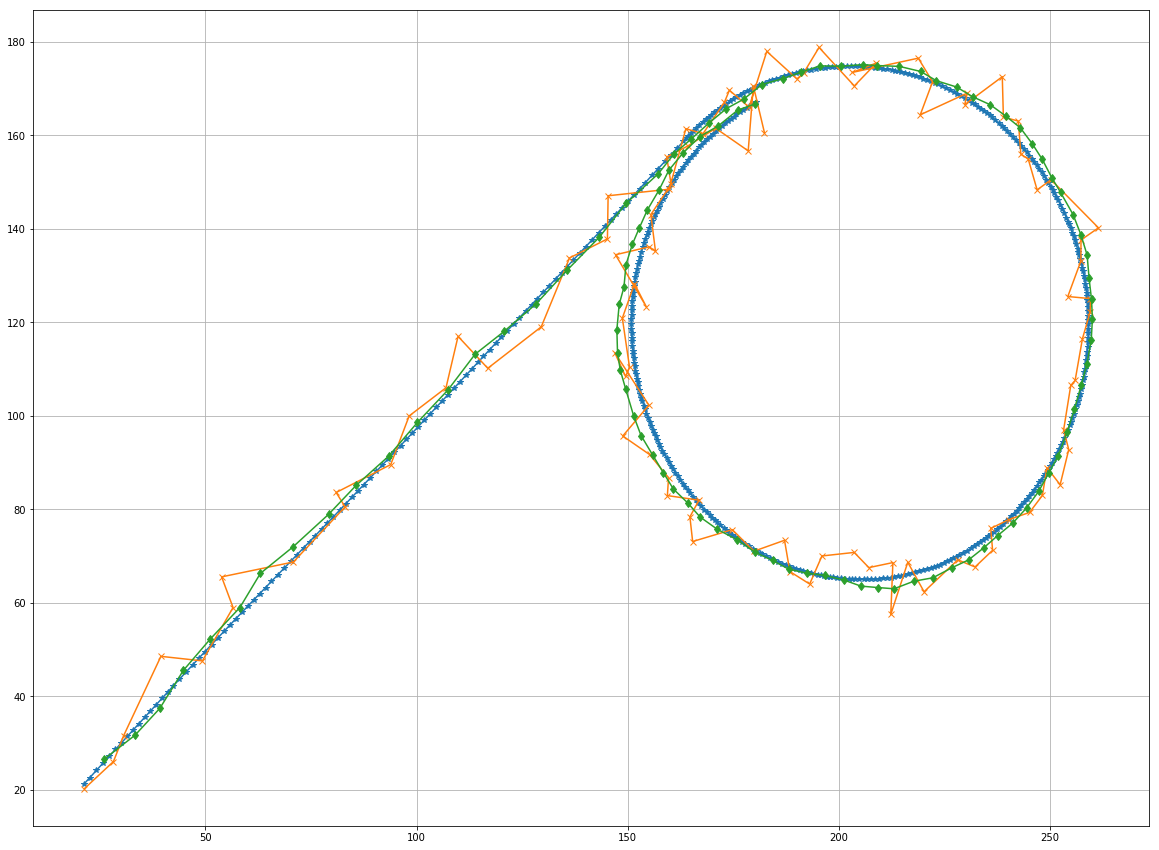

In [115]:

# Simulation: This is only a test. May need to modify later
dt = 0.1
T = 50
u = np.array((1,1))
Scott = myRobot()
x = Scott.x
e = Scott.motor_err

x_traj = []
y_traj = []
x_priori = []
y_priori = []
x_post = []
y_post = []
x_measure = []
y_measure = []

temp_avg = []

for i in range(0,int(T/dt)+1):
    if i >= 100:
        u = np.array([0.8,0.1])
    u_actual = u + e*randn(2)
    x = Scott.move(x,dt,u_actual)
    x_traj.append(x[0])
    y_traj.append(x[1])
    if i % 5 == 0:
        Scott.predict(u)
        x_priori.append(Scott.x[0])
        y_priori.append(Scott.x[1])
        z = Scott.measure(x)
        temp_avg.append(z[3])
        x_measure.append(z[0])
        y_measure.append(z[1])
        y = Scott.residual(z)
        Scott.update(y)
        x_post.append(Scott.x[0])
        y_post.append(Scott.x[1])
    
        
        
        
        

plt.figure(figsize = (20,15))
plt.grid(True)
#plt.xlim((0,750))
#plt.ylim(0,500)
plt.plot(x_traj,y_traj,marker = '*')
#plt.plot(x_priori,y_priori,marker = 'o') 
plt.plot(x_measure,y_measure, marker = 'x')
plt.plot(x_post,y_post, marker = 'd')


